In [ ]:
# this notebook is to test run the custom stock trading environment

In [ ]:
# test sentiment analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import datetime as dt

# set up tokenizer and model for sentiment analysis
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)

In [ ]:

from getstock import get_newsheadline_sentiment, get_stock_data_yf_between_with_indicators_news
# test get_newsheadline_sentiment and get__stock_data_with_news with TSLA, and the last 3 days
indicators = ["Volume", "volume_cmf", "trend_macd", "momentum_rsi", "momentum_stoch_rsi", "trend_sma_fast"]
symbol = 'TSLA'
#end_date = dt.datetime.now()
#start_date = end_date - dt.timedelta(days=3)

# set start time to be 2022-01-01 and end time to be 2022-01-02
start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2022, 3, 1)
start_date_string = start_date.strftime("%Y-%m-%d")
end_date_string = end_date.strftime("%Y-%m-%d")
#result = get_newsheadline_sentiment(symbol, start_date, end_date, device, tokenizer, model)
data = get_stock_data_yf_between_with_indicators_news(symbol, start_date_string, end_date_string, "1d", indicators)


In [ ]:
data


In [ ]:
# this library is to get the list of tickers from NASDAQ and S&P500
from gettickers import *

nasdaq_tic = get_nasdaq_tickers()
#sp500_tic = get_sp500_tickers()
dow_tic = get_dow_tickers()
#nyse_tic = get_nyse_tickers()
#dow_tic = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']

# merge the lists and remove duplicates
all_tickers = nasdaq_tic + dow_tic
all_tickers = list(set(all_tickers))
print(len(nasdaq_tic))
#print(len(sp500_tic))
print(len(dow_tic))
print(len(all_tickers))
# loop through tickers and only keep the ones with capital letters
# this is to remove the tickers with special characters

In [1]:
# create json files for all tickers for stable_baselines agent training
start_date = "2017-01-01"
num_days = 400
interval = "1d"
indicators = ["Volume", "volume_cmf", "trend_macd", "momentum_rsi", "momentum_stoch_rsi", "trend_sma_fast"]
init_balance = 20000
agent_output_path = "trained_stable_agents_2/"
stable_training_json_path = "training_stable_agents_config/"
#create_json_files(all_tickers, start_date, num_days, interval, indicators, init_balance, agent_output_path, stable_training_json_path)

In [2]:
# create json files for all tickers for decision transformer offline data generation
from datetime import datetime, timedelta
# calculate the new start_date as the above start_date + num_days
start_date = datetime.strptime(start_date, "%Y-%m-%d")
new_start_date = start_date + timedelta(days=num_days)

# calculate the day different between current date and new_start_date
today = datetime.today().strftime("%Y-%m-%d")
today = datetime.strptime(today, "%Y-%m-%d")
day_diff = (today - new_start_date).days

if day_diff < 120:
    num_days = day_diff
else:
    num_days = day_diff - 120

new_start_date = new_start_date.strftime("%Y-%m-%d")
output_path = "offline_stock_trade_data/"
data_json_path = "offline_stock_trade_data_config/"
#create_json_files(all_tickers, new_start_date, num_days, interval, indicators, init_balance, output_path, data_json_path)

In [ ]:
import os
import re
import json


# import libraries for training stable baselines agent
from train_stable_agent import create_stable_agents, evaluate_stable_agent, train_stable_agent, output_stable_agent, full_run

from stable_baselines3.common.env_checker import check_env

# import custom functions and classes
from curatedataset import makegymenv, run_env, full_curate_run

from get_agent import Agent, TradingAlgorithm


In [ ]:
# open directory from json_path
json_files = os.listdir(stable_training_json_path)

# loop through all json file and train stablebaseline agent with full_run
for file in json_files:
    # check if file ends with json
    if file.endswith(".json"):
        runfile = os.path.join(stable_training_json_path, file)
        print(f"Training agent with {runfile}")
        with open(runfile, "r") as f:
            runconfig = json.load(f)
        output_path = runconfig["output_path"]
        if os.path.exists(output_path) and len(os.listdir(output_path)) == 3:
            print(f"Agent with {runfile} already trained")
            continue
        else:
            try:
                full_run(runfile)
            except Exception as e:
                print(f"Error training agent with {runfile}")
                print(e)
                continue


In [ ]:
# Initialize counters
bad_count = 0
good_count = 0

# Loop through files in the output path and its subfolders
for root, dirs, files in os.walk(agent_output_path):
    for file in files:
        if file.endswith(".zip"):
            if "bad" in file:
                bad_count += 1
            elif "good" in file:
                good_count += 1

print(f"Number of files with 'bad' in the name: {bad_count}")
print(f"Number of files with 'good' in the name: {good_count}")


In [ ]:
data_json_files = os.listdir(data_json_path)

# loop through all json file and run environment with trained stable agent and other algorithms
for file in data_json_files:
    # check if file ends with json
    if file.endswith(".json"):
        runfile = os.path.join(data_json_path, file)
        print(f"Curating data with {runfile}")
        # open the json file and read the content
        with open(runfile, 'r') as f:
            data = json.load(f)
        # get the ticker
        ticker = data['stock_name']
        output = data["output_path"]
        # check if the output path exists and if it contain data, if so skip
        if os.path.exists(output) and len(os.listdir(output)) > 0:
            print(f"Data already curated for {ticker}")
            continue
        else:
            try:
                # joining the output path with ticker
                trained_stable_agent_path = os.path.join(agent_output_path, ticker)
                full_curate_run(runfile, trained_stable_agent_path, num_episodes=80)
            except Exception as e:
                print(f"Error curating data with {runfile}")
                print(e)
                continue

In [ ]:
from curatedataset import calc_meanstd_datasets

dataset_meanstd = calc_meanstd_datasets(output_path,['positive', 'negative', 'neutral'])

In [ ]:
from train_decision_transformer import full_training_run, save_model

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model, trained_params = full_training_run(output_path, device = device, force_normalize=dataset_meanstd, n_epochs = 40)

In [ ]:
model_name = 'nasdaq_dow_news_2'
model_path = 'trained_nasdaq_dow_decision_transformer'
save_model(trained_model, trained_params, model_name, model_path)

In [3]:
from curatedataset import eval_reward_datasets
mean_rewards = eval_reward_datasets(output_path)

shape: (1, 7)
┌────────────┬────────────┬────────────┬─────────────┬────────────┬───────────┬───────────┐
│ reward_min ┆ reward_max ┆ reward_10  ┆ reward_25   ┆ reward_50  ┆ reward_75 ┆ reward_90 │
│ ---        ┆ ---        ┆ ---        ┆ ---         ┆ ---        ┆ ---       ┆ ---       │
│ f64        ┆ f64        ┆ f64        ┆ f64         ┆ f64        ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═════════════╪════════════╪═══════════╪═══════════╡
│ -589.13181 ┆ 465.624915 ┆ -198.15058 ┆ -125.586757 ┆ -64.339423 ┆ 7.249499  ┆ 88.915637 │
└────────────┴────────────┴────────────┴─────────────┴────────────┴───────────┴───────────┘


In [4]:
mean_rewards['reward_75'][0]

7.24949879807864

In [5]:
# read normalized mean and std from model param
import json
import os
from TradingEnvClass import MeanStdObject
model_name = 'nasdaq_dow_news_2'
model_path = 'trained_nasdaq_dow_decision_transformer'
# get file ends with json
json_files = [file for file in os.listdir(model_path) if file.endswith('params.json')]
parameter_path = os.path.join(model_path, json_files[0])
with open(parameter_path, 'r') as f:
    normalize = json.load(f)["normalize"]

In [6]:
mean_std_dict = {key: MeanStdObject(mean = value['mean'], std=value['std']) for key, value in normalize.items()}


In [8]:
from curatedataset import makegymenv, run_env
test_tic = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN', 'META', 'NVDA', 'INTC', 'AMD']
# make gym environment
stock_name = test_tic[3]
# TODO test different start date within the dataset 
start_date = '2022-06-01'
num_days = 365
interval = '1d'
indicators = ["Volume", "volume_cmf", "trend_macd", "momentum_rsi", "momentum_stoch_rsi", "trend_sma_fast"]
init_balance = 20000
#data = get_stock_data_yf_between_with_indicators(stock_name, '2019-01-01', '2020-02-01', interval, ['all'])

env,obs_space, act_space, col, data = makegymenv(stock_name, start_date, num_days, interval, indicators=indicators, normalize=mean_std_dict, init_balance=init_balance)


Getting stock data of TSLA...


/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '258.3132098388672' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


sorting indicators...
setting up sentiment analysis model...


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Getting news sentiment of TSLA...
Getting stock data of TSLA completed.
init env with max step:  250


/code/src/curatedataset.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/code/src/curatedataset.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [9]:
from get_agent import Agent
import torch
import fnmatch
# get model parameter's path under model path by checking for _params.json
f = os.listdir(model_path)
matching_files = fnmatch.filter(f, model_name+'*_params.json')

# pick the 90th percentile reward as the target reward
rtg_target = mean_rewards['reward_75'][0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DecisionTransformer = Agent(env, 'transformer', rtg_target=rtg_target, rtg_scale=0.7, model_path=parameter_path, device=device)

In [10]:
trade_data = run_env(DecisionTransformer, stock_name, env, 10, start_date, normalize_param = normalize)

Episode:  0 Timestep: 15  done
Episode:  1 Timestep: 13  done
Episode:  2 Timestep: 13  done
Episode:  3 Timestep: 13  done
Episode:  4 Timestep: 13  done
Episode:  5 Timestep: 13  done
Episode:  6 Timestep: 13  done
Episode:  7 Timestep: 13  done
Episode:  8 Timestep: 13  done
Episode:  9 Timestep: 13  done


In [11]:
from curatedataset import save_data
file_name = os.path.join(model_path, 'trained_transformer_'+stock_name+'_'+start_date+'_test.json')
save_data(trade_data, file_name)

Mean sample sum reward:  -1728.2036087350043
Std sample sum reward:  159.4327063284513
Mean net worth growth:  -1415.31953125
Std net worth growth: +/- 723.454447086214
Plotting episode:  4
check:  <class 'numpy.ndarray'>


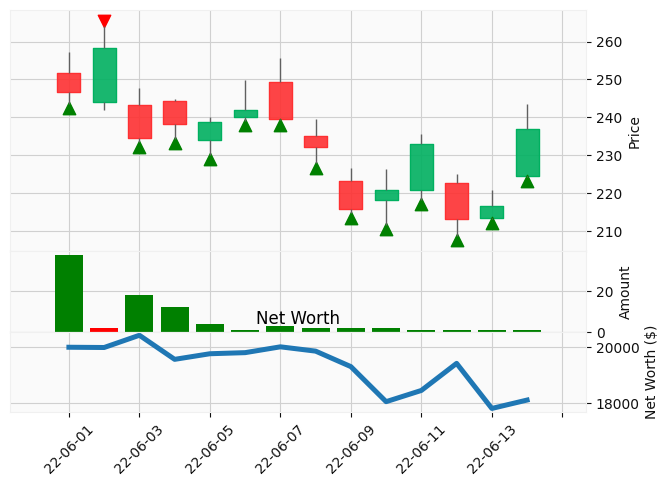

In [1]:
from curatedataset import evaluate_dataset
eval_data = "trained_nasdaq_dow_decision_transformer/trained_transformer_TSLA_2022-06-01_test.json"
# eval_data = file_name
evaluate_dataset(eval_data)